In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import plotly.graph_objects as go
import plotly.figure_factory as ff
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

In [ ]:
sns.set_style('darkgrid')
sns.set(font_scale=1.3)
WATER_QUALITY = pd.read_csv('water_quality_.csv')
print(WATER_QUALITY)

            ph    Hardness       Solids  Chloramines     Sulfate  \
0          NaN  204.890456  20791.31898     7.300212  368.516441   
1     3.716080  129.422921  18630.05786     6.635246         NaN   
2     8.099124  224.236259  19909.54173     9.275884         NaN   
3     8.316766  214.373394  22018.41744     8.059332  356.886136   
4     9.092223  181.101509  17978.98634     6.546600  310.135738   
...        ...         ...          ...          ...         ...   
3271  4.668102  193.681736  47580.99160     7.166639  359.948574   
3272  7.808856  193.553212  17329.80216     8.061362         NaN   
3273  9.419510  175.762646  33155.57822     7.350233         NaN   
3274  5.126763  230.603758  11983.86938     6.303357         NaN   
3275  7.874671  195.102299  17404.17706     7.509306         NaN   

      Organic_carbon  Trihalomethanes  Turbidity  Check  
0          10.379783        86.990970   2.963135      0  
1          15.180013        56.329076   4.500656      0  
2        

In [ ]:
WATER_QUALITY.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Check                0
dtype: int64

In [ ]:
for col in WATER_QUALITY.columns:
    pct_missing = np.mean(WATER_QUALITY[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

ph - 15%
Hardness - 0%
Solids - 0%
Chloramines - 0%
Sulfate - 24%
Organic_carbon - 0%
Trihalomethanes - 5%
Turbidity - 0%
Check - 0%


created missing indicator for: ph
created missing indicator for: Sulfate
created missing indicator for: Trihalomethanes


<Axes: xlabel='index'>

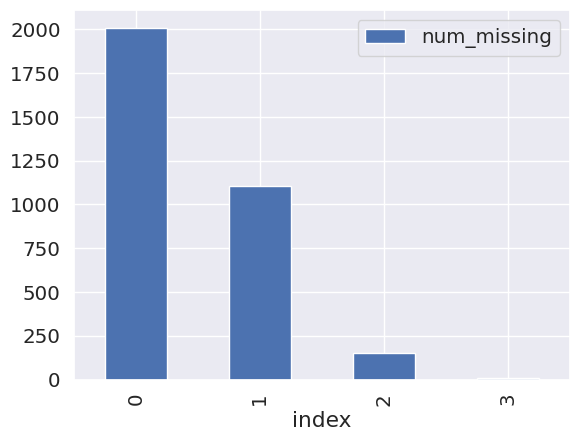

In [ ]:
for col in WATER_QUALITY.columns:
    missing = WATER_QUALITY[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:
        print('created missing indicator for: {}'.format(col))
        WATER_QUALITY['{}_ismissing'.format(col)] = missing

ismissing_cols = [col for col in WATER_QUALITY.columns if 'ismissing' in col]
WATER_QUALITY['num_missing'] = WATER_QUALITY[ismissing_cols].sum(axis=1)

WATER_QUALITY['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')

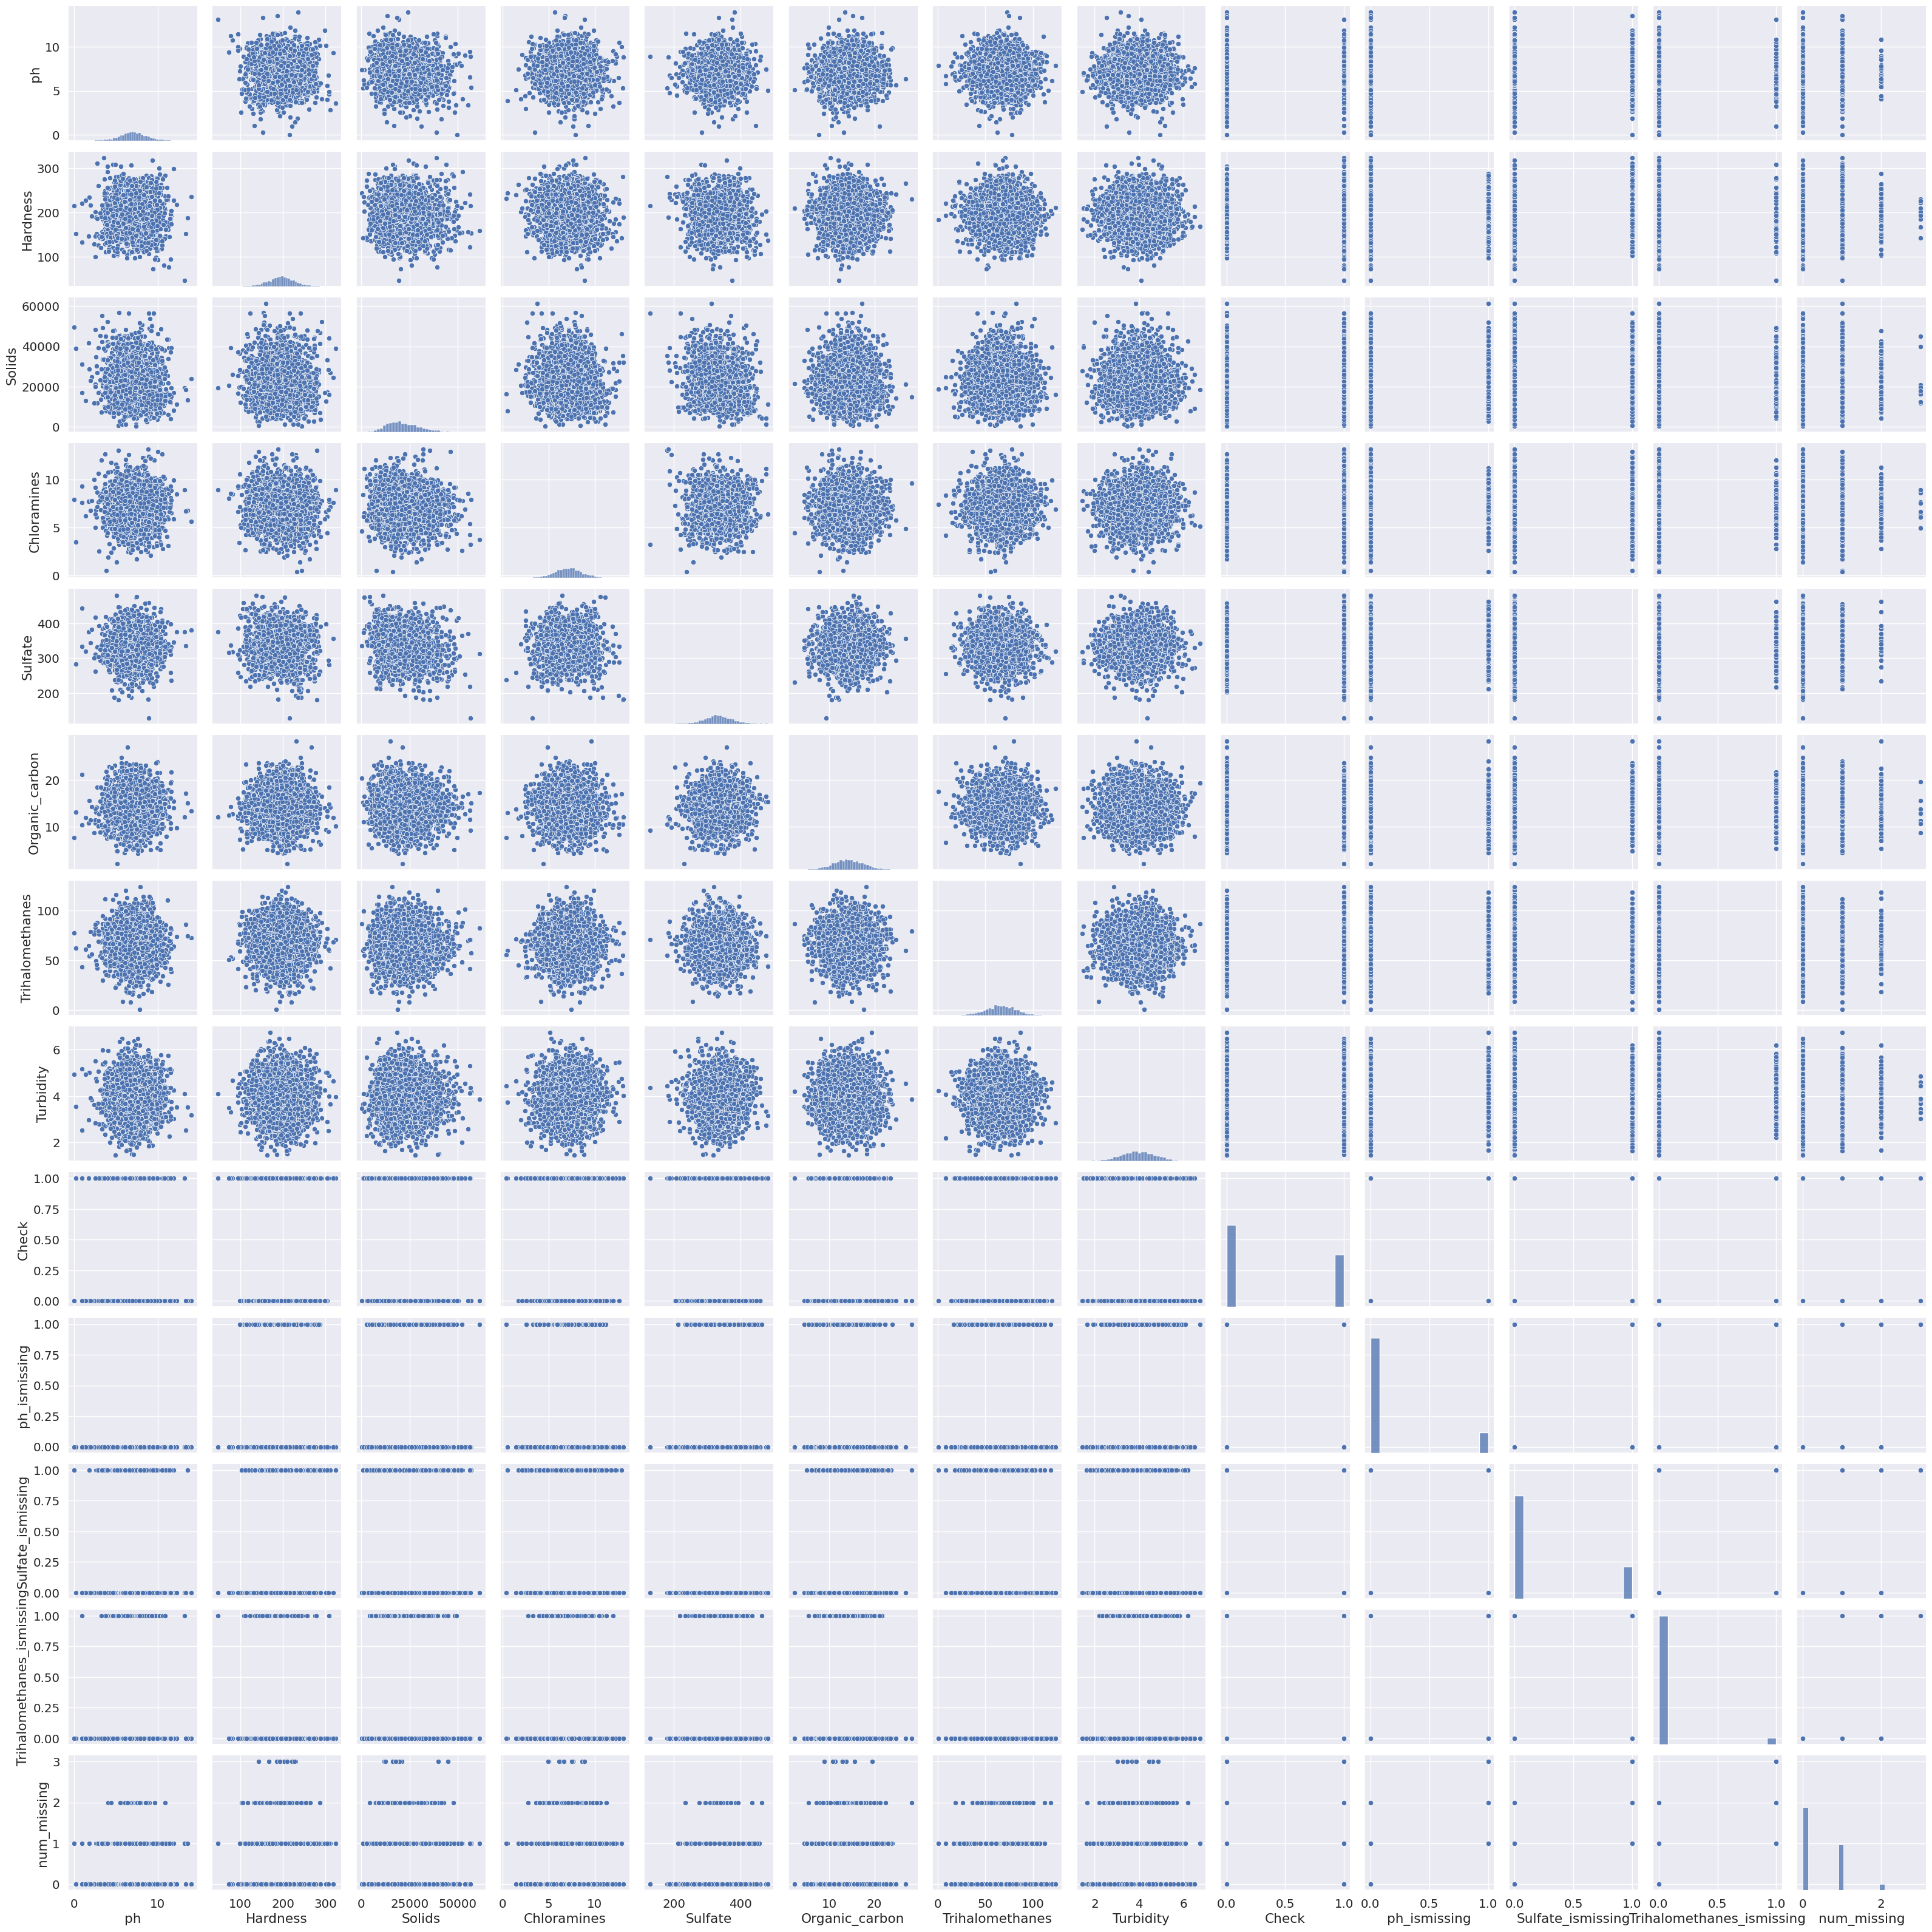

In [ ]:
sns.pairplot(WATER_QUALITY)

In [ ]:
# impute the missing values and create the missing value indicator variables for each numeric column.
df_numeric = WATER_QUALITY.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

for col in numeric_cols:
    missing = WATER_QUALITY[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        print('imputing missing values for: {}'.format(col))
        WATER_QUALITY['{}_ismissing'.format(col)] = missing
        med = WATER_QUALITY[col].median()
        WATER_QUALITY[col] = WATER_QUALITY[col].fillna(med)
print(WATER_QUALITY)

imputing missing values for: ph
imputing missing values for: Sulfate
imputing missing values for: Trihalomethanes
            ph    Hardness       Solids  Chloramines     Sulfate  \
0     7.036752  204.890456  20791.31898     7.300212  368.516441   
1     3.716080  129.422921  18630.05786     6.635246  333.073546   
2     8.099124  224.236259  19909.54173     9.275884  333.073546   
3     8.316766  214.373394  22018.41744     8.059332  356.886136   
4     9.092223  181.101509  17978.98634     6.546600  310.135738   
...        ...         ...          ...          ...         ...   
3271  4.668102  193.681736  47580.99160     7.166639  359.948574   
3272  7.808856  193.553212  17329.80216     8.061362  333.073546   
3273  9.419510  175.762646  33155.57822     7.350233  333.073546   
3274  5.126763  230.603758  11983.86938     6.303357  333.073546   
3275  7.874671  195.102299  17404.17706     7.509306  333.073546   

      Organic_carbon  Trihalomethanes  Turbidity  Check  ph_ismissing

In [ ]:
WATER_QUALITY.isnull().sum()

ph                           0
Hardness                     0
Solids                       0
Chloramines                  0
Sulfate                      0
Organic_carbon               0
Trihalomethanes              0
Turbidity                    0
Check                        0
ph_ismissing                 0
Sulfate_ismissing            0
Trihalomethanes_ismissing    0
num_missing                  0
dtype: int64

In [ ]:
selected_columns = ['Sulfate', 'Hardness']
WATER_QUALITY['Sulfate'] = pd.to_numeric(WATER_QUALITY['Sulfate'], errors='coerce')
WATER_QUALITY['Hardness'] = pd.to_numeric(WATER_QUALITY['Hardness'], errors='coerce')
BASE_WATER_QUALITY = WATER_QUALITY[selected_columns]


In [ ]:
inertia_values = []
davies_bouldin_scores = []
silhouette_scores = []

possible_k_values = range(2, 11)

for k in possible_k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(BASE_WATER_QUALITY)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(BASE_WATER_QUALITY, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(BASE_WATER_QUALITY, kmeans.labels_))


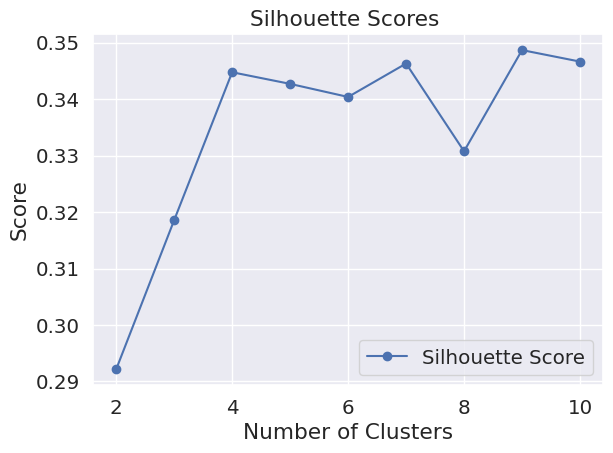

In [ ]:
plt.plot(possible_k_values, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores ')
plt.legend()
plt.tight_layout()
plt.show()

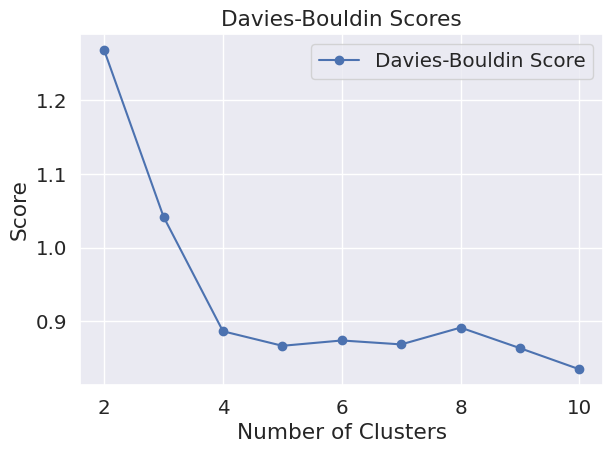

In [ ]:
plt.plot(possible_k_values, davies_bouldin_scores, marker='o', label='Davies-Bouldin Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Davies-Bouldin Scores')
plt.legend()
plt.tight_layout()
plt.show()

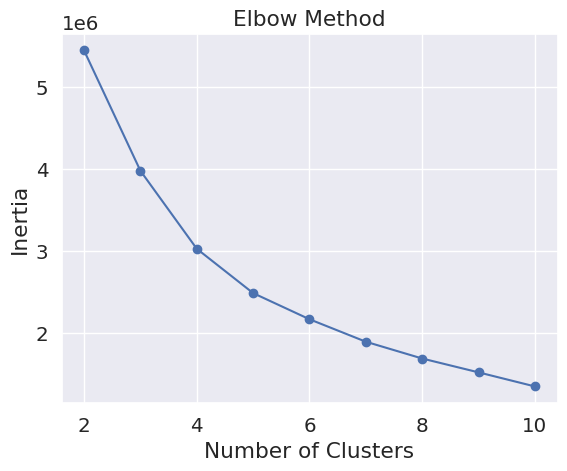

In [ ]:
#Метод локтя

plt.plot(possible_k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
Opt_clust = 5

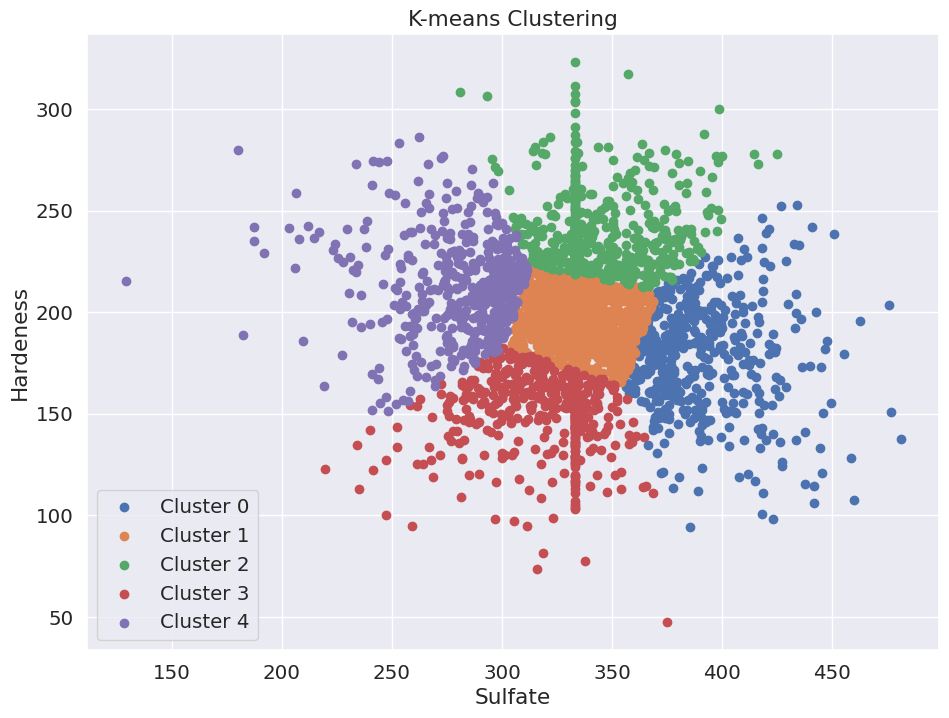

In [ ]:
kmeans = KMeans(n_clusters=Opt_clust, random_state=42)
WATER_QUALITY['cluster'] = kmeans.fit_predict(BASE_WATER_QUALITY)

plt.figure(figsize=(11, 8))
for cluster in range(Opt_clust):
    cluster_data = WATER_QUALITY.loc[WATER_QUALITY['cluster'] == cluster]
    plt.scatter(cluster_data['Sulfate'], cluster_data['Hardness'], label=f'Cluster {cluster}')
plt.xlabel('Sulfate')
plt.ylabel('Hardeness')
plt.title('K-means Clustering')
plt.legend()
plt.show()

In [ ]:
kmeans_silhouette = silhouette_score(BASE_WATER_QUALITY, kmeans.labels_)
kmeans_db = davies_bouldin_score(BASE_WATER_QUALITY, kmeans.labels_)
kmeans_ch = calinski_harabasz_score(BASE_WATER_QUALITY, kmeans.labels_)

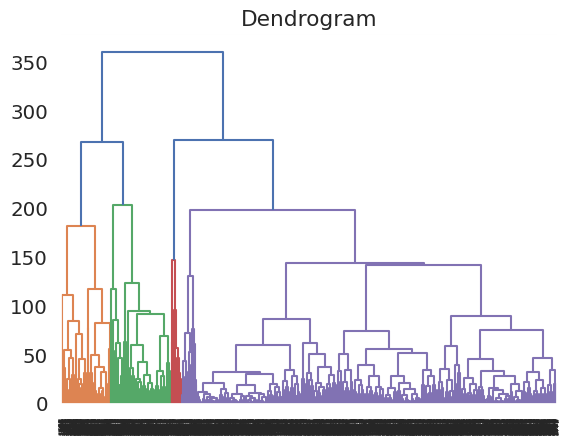

In [ ]:
dist_matrix = hierarchy.distance.pdist(BASE_WATER_QUALITY)

linkage_matrix = hierarchy.linkage(dist_matrix, 'complete')
dendrogram = hierarchy.dendrogram(linkage_matrix)

plt.title('Dendrogram')
plt.show()


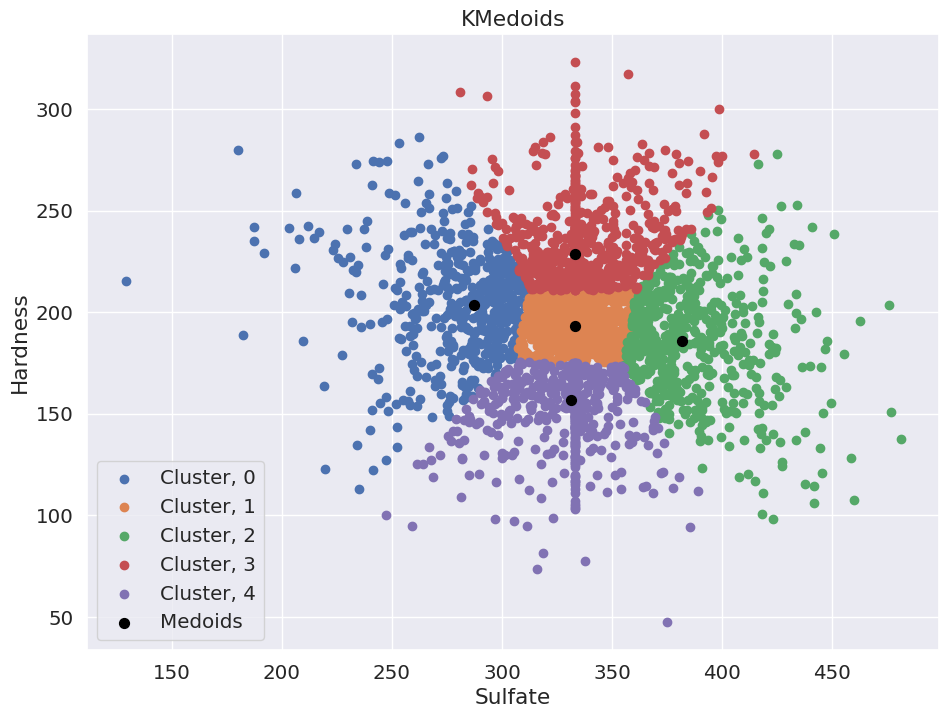

In [ ]:
kmedoids = KMedoids(n_clusters=Opt_clust, random_state=42)
kmedoids.fit(BASE_WATER_QUALITY)

labels = kmedoids.labels_
medoids = BASE_WATER_QUALITY.iloc[kmedoids.medoid_indices_]

plt.figure(figsize=(11, 8))
for cluster_label in range(Opt_clust):
    cluster_points = BASE_WATER_QUALITY[labels == cluster_label]
    plt.scatter(cluster_points['Sulfate'], cluster_points['Hardness'], label=f'Cluster, {cluster_label}')

plt.scatter(medoids['Sulfate'], medoids['Hardness'], c='Black', marker='o', s=50, label='Medoids')
plt.xlabel('Sulfate')
plt.ylabel('Hardness')
plt.legend()
plt.title('KMedoids')
plt.show()


In [ ]:
kmedoids_silhouette = silhouette_score(BASE_WATER_QUALITY, kmedoids.labels_)
kmedoids_db = davies_bouldin_score(BASE_WATER_QUALITY, kmedoids.labels_)
kmedoids_ch = calinski_harabasz_score(BASE_WATER_QUALITY, kmedoids.labels_)

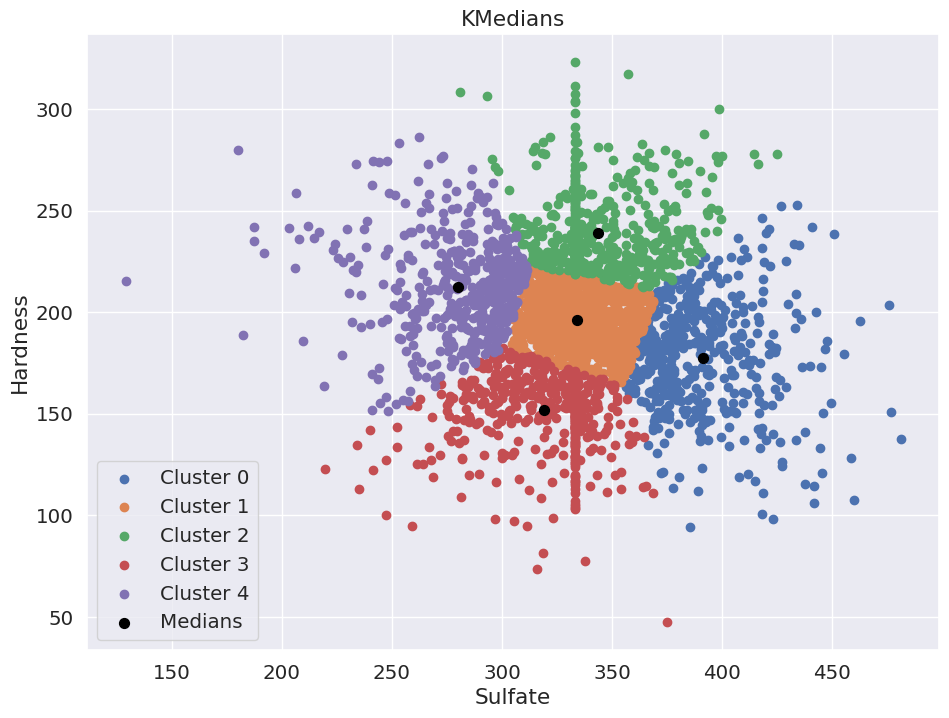

In [ ]:

kmedians = KMeans(n_clusters=Opt_clust, random_state=42)
kmedians.fit(BASE_WATER_QUALITY)

labels = kmedians.labels_
medians = kmedians.cluster_centers_

plt.figure(figsize=(11, 8))
for cluster_label in range(Opt_clust):
    cluster_points = BASE_WATER_QUALITY[labels == cluster_label]
    plt.scatter(cluster_points['Sulfate'], cluster_points['Hardness'], label=f'Cluster {cluster_label}')

plt.scatter(medians[:, 0], medians[:, 1], c='black', marker='o', s=50, label='Medians')
plt.xlabel('Sulfate')
plt.ylabel('Hardness')
plt.legend()
plt.title('KMedians')
plt.show()

In [ ]:
kmedians_silhouette = silhouette_score(BASE_WATER_QUALITY, kmedians.labels_)
kmedians_db = davies_bouldin_score(BASE_WATER_QUALITY, kmedians.labels_)
kmedians_ch = calinski_harabasz_score(BASE_WATER_QUALITY, kmedians.labels_)

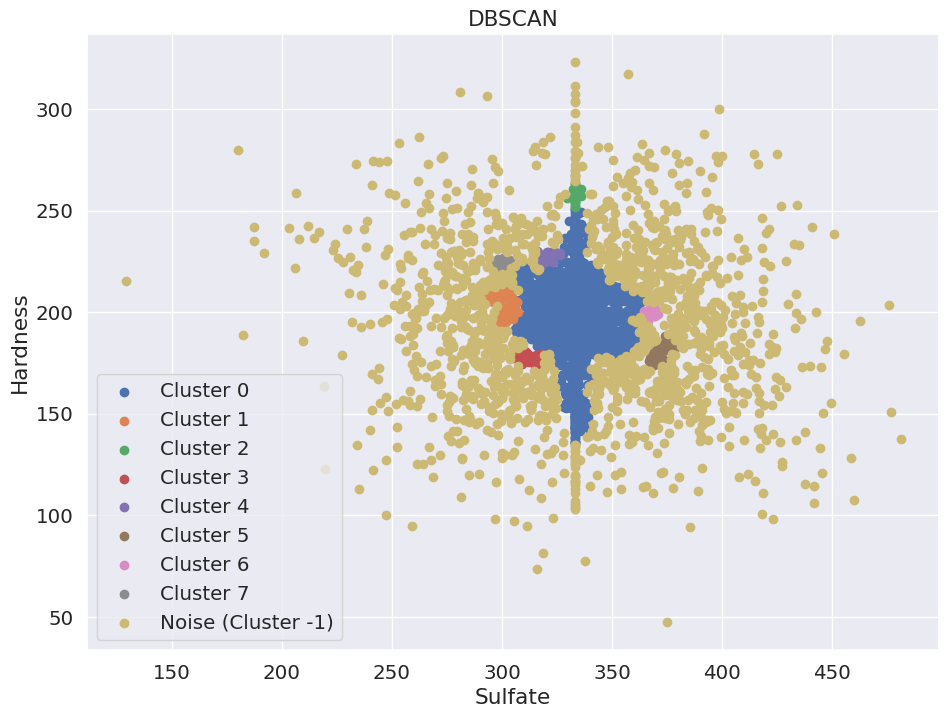

In [ ]:
dbscan = DBSCAN(eps=4, min_samples=15)
dbscan.fit(BASE_WATER_QUALITY)

labels = dbscan.labels_

plt.figure(figsize=(11, 8))
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        cluster_points = BASE_WATER_QUALITY[labels == label]
        plt.scatter(cluster_points['Sulfate'], cluster_points['Hardness'], label=f'Noise (Cluster {label})')
    else:
        cluster_points = BASE_WATER_QUALITY[labels == label]
        plt.scatter(cluster_points['Sulfate'], cluster_points['Hardness'], label=f'Cluster {label}')

plt.xlabel('Sulfate')
plt.ylabel('Hardness')
plt.legend()
plt.title('DBSCAN')
plt.show()

In [ ]:
dbscan_silhouette = silhouette_score(BASE_WATER_QUALITY, dbscan.labels_)
dbscan_db = davies_bouldin_score(BASE_WATER_QUALITY, dbscan.labels_)
dbscan_ch = calinski_harabasz_score(BASE_WATER_QUALITY, dbscan.labels_)

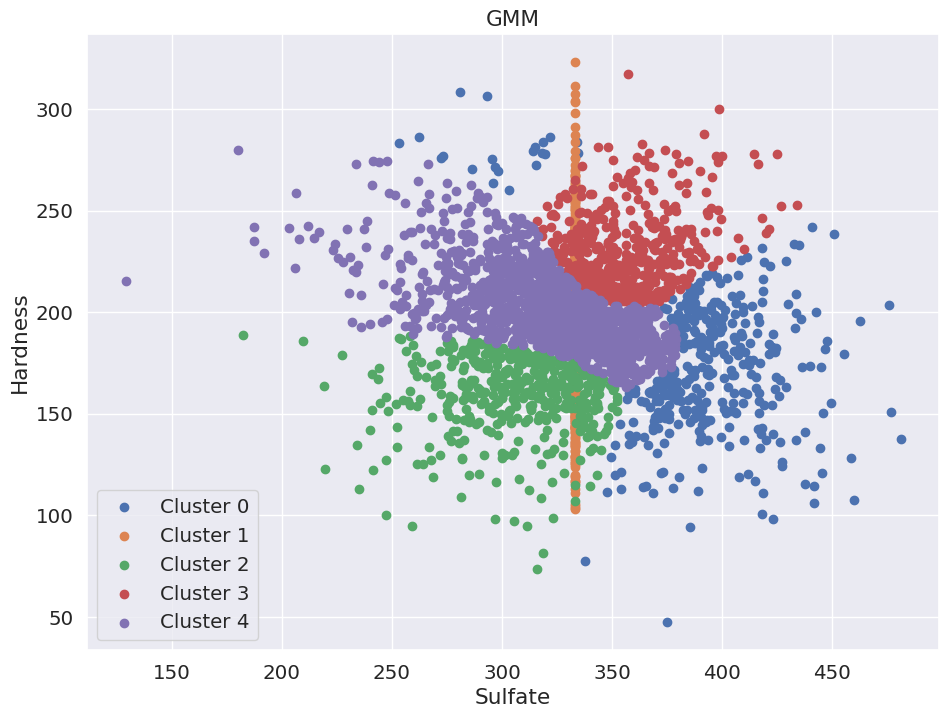

In [ ]:
gmm = GaussianMixture(n_components=Opt_clust, random_state=42)
gmm.fit(BASE_WATER_QUALITY)

labels = gmm.predict(BASE_WATER_QUALITY)

plt.figure(figsize=(11, 8))
for cluster_label in range(Opt_clust):
    cluster_points = BASE_WATER_QUALITY[labels == cluster_label]
    plt.scatter(cluster_points['Sulfate'], cluster_points['Hardness'], label=f'Cluster {cluster_label}')

plt.xlabel('Sulfate')
plt.ylabel('Hardness')
plt.legend()
plt.title('GMM')
plt.show()

In [ ]:
gmm_labels = gmm.predict(BASE_WATER_QUALITY)
gmm_silhouette = silhouette_score(BASE_WATER_QUALITY, gmm_labels)
gmm_db = davies_bouldin_score(BASE_WATER_QUALITY, gmm_labels)
gmm_ch = calinski_harabasz_score(BASE_WATER_QUALITY, gmm_labels)

In [ ]:
data = {'methods':['kmeans','kmedoids','kmedians','DBSCAN', 'GMM'],
 'silhouette Score': [kmeans_silhouette,kmedoids_silhouette,kmedians_silhouette,dbscan_silhouette, gmm_silhouette],
  'davies-Bouldin Index': [kmeans_db,kmedoids_db,kmedians_db,dbscan_db, gmm_db],
  'calinski-Harabasz Index': [kmeans_ch,kmedoids_ch, kmedians_ch,dbscan_ch, gmm_ch]}

Table = pd.DataFrame(data)
print(Table)

    methods  silhouette Score  davies-Bouldin Index  calinski-Harabasz Index
0    kmeans          0.342716              0.866894              1757.228616
1  kmedoids          0.303765              0.861633              1674.131423
2  kmedians          0.342716              0.866894              1757.228616
3    DBSCAN         -0.344664              6.402174                18.308452
4       GMM          0.084141              2.253395               606.520345


По совокупности факторов самым подходящим и точным методом в данном случае является K-медоидов, так как по силуэту и Давье-Болдину значения минимальные, и сравнимо высокое значение по Калински